<u><b>Computer Vision

<u><b>Name: Aditya Kumar Das  </b></u>

<u><b>Enrollment No: 07519051622 </b></u>

<u><b>Lab - 6 : </b></u> Object recognition using HOG and
machine learning.

# **OBJECTIVE**
to detect object using HOG(Histogram of Oriented Gradients)

The Histogram of Oriented Gradients (HOG) transforms an image into a feature vector that describes object shapes by analyzing gradient directions, used for tasks like object detection. Below are the steps HOG follows, with mathematical formulas and operators, including Sobel and max, culminating in a histogram display of features.

### Step 1: Fetch image
 Fetch the Image

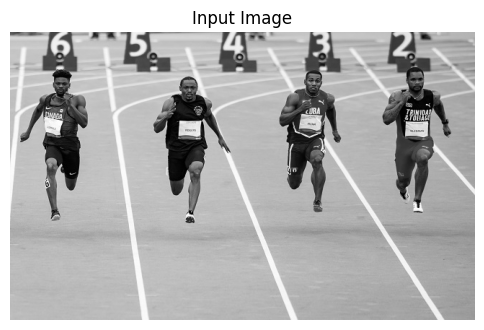

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load and preprocess image
image = cv2.imread('/content/pexels-jopwell-2422290.jpg', cv2.IMREAD_GRAYSCALE)
if image is None:
    print("Error: Could not load image")
    exit()
# Display input image
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.show()


### Step 2: Compute Gradients

- **Purpose**: Detect edges by calculating intensity changes.
- **Process**: Use Sobel operators to compute horizontal ($G_x$) and vertical ($G_y$) gradients per pixel.
- **Math**:

  **Sobel kernels**:

  $$
  G_x = I *
  \begin{bmatrix}
  -1 & 0 & 1 \\
  -2 & 0 & 2 \\
  -1 & 0 & 1
  \end{bmatrix}
  , \quad
  G_y = I *
  \begin{bmatrix}
  -1 & -2 & -1 \\
   0 &  0 &  0 \\
   1 &  2 &  1
  \end{bmatrix}
  $$

  where $I$ is intensity, and $*$ denotes convolution.

  **Magnitude**:

  $$
  |G| = \sqrt{G_x^2 + G_y^2}
  $$

  **Orientation**:

  $$
  \theta = \arctan\left(\frac{G_y}{G_x}\right)
  $$

  Adjusted to $0^\circ$–$180^\circ$ (unsigned).

- **Operators**: Sobel convolution, square root, arctangent.
- **Outcome**: Gradient map with direction ($\theta$) and strength ($|G|$) per pixel.


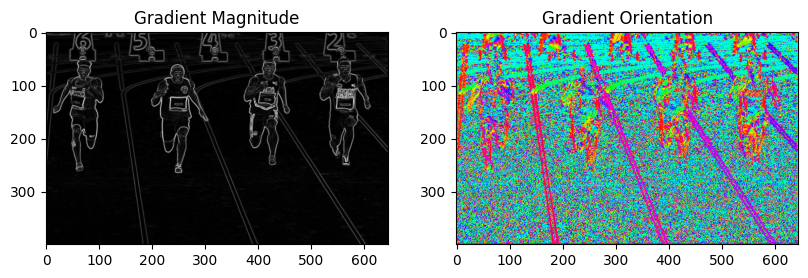

In [ ]:
def compute_gradients(img):
    # Sobel operators
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    Gx = cv2.filter2D(img, cv2.CV_64F, sobel_x)  # Convolution
    Gy = cv2.filter2D(img, cv2.CV_64F, sobel_y)
    magnitude = np.sqrt(Gx**2 + Gy**2)  # Magnitude
    orientation = np.arctan2(Gy, Gx) * (180 / np.pi) % 180  # Orientation
    return magnitude, orientation, max_gradient

magnitude, orientation, max_gradient = compute_gradients(image)

# Visualize
plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(magnitude, cmap='gray'), plt.title('Gradient Magnitude')
plt.subplot(132), plt.imshow(orientation, cmap='hsv'), plt.title('Gradient Orientation')
plt.show()

### Step 3: Divide Image into Cells

- **Purpose**: Capture local edge patterns in small regions.
- **Process**: Divide the image into a grid of square cells. Create a histogram of gradient orientations per cell.
- **Math**:

  - Divide $0^\circ$–$180^\circ$ into $N$ bins (e.g., $N = 9$ → $20^\circ$ per bin).
  - For a pixel with orientation $\theta$ and magnitude $|G|$, contribute $|G|$ to the appropriate bin(s) — with optional interpolation.

- **Operators**: Binning, linear interpolation.
- **Outcome**: Each cell yields a histogram (e.g., 9 values) of edge directions.

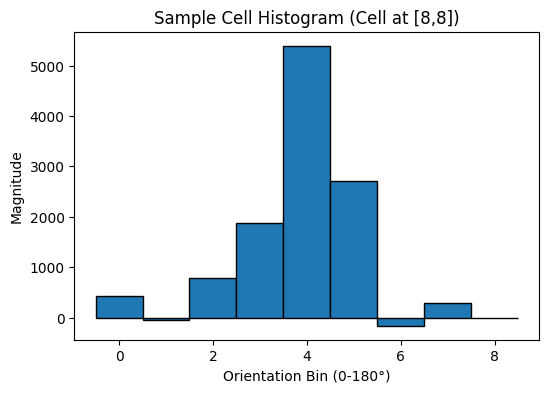

In [ ]:
cell_size = 8
num_bins = 9
histograms = []
for y in range(0, 128, cell_size):
    for x in range(0, 128, cell_size):
        cell_magnitude = magnitude[y:y+cell_size, x:x+cell_size]
        cell_orientation = orientation[y:y+cell_size, x:x+cell_size]
        hist = np.zeros(num_bins)
        for i in range(cell_size):
            for j in range(cell_size):
                theta = cell_orientation[i, j]
                mag = cell_magnitude[i, j]
                bin_idx = int(theta // (180 / num_bins))
                bin_center = (bin_idx + 0.5) * (180 / num_bins)
                if bin_idx < num_bins - 1:
                    next_bin = bin_idx + 1
                    weight = (theta - bin_center) / (180 / num_bins)
                    hist[bin_idx] += mag * (1 - weight)
                    hist[next_bin] += mag * weight
                else:
                    hist[bin_idx] += mag
        histograms.append(hist)
histograms = np.array(histograms).reshape(16, 16, num_bins)

# Visualize sample cell histogram
plt.figure(figsize=(6, 4))
plt.bar(range(num_bins), histograms[8, 8], width=1.0, edgecolor='black')
plt.title('Sample Cell Histogram (Cell at [8,8])')
plt.xlabel('Orientation Bin (0-180°)')
plt.ylabel('Magnitude')
plt.show()

### Step 4: Group Cells into Blocks

- **Purpose**: Combine cells for robust feature extraction.
- **Process**: Group neighboring cells (e.g., $2 \times 2$) into overlapping blocks. Concatenate histograms from cells within each block.
- **Math**:

  - Each block includes $M$ cells.
  - If $M = 4$ and each cell has 9 bins: $4 \times 9 = 36$ values per block.

- **Operators**: Concatenation, max (if needed to cap or clip).
- **Outcome**: A single block histogram representing regional gradient patterns.

In [ ]:
block_size = 2
block_stride = 1
blocks = []
for y in range(0, 16 - block_size + 1, block_stride):
    for x in range(0, 16 - block_size + 1, block_stride):
        block_hist = histograms[y:y+block_size, x:x+block_size].reshape(-1)
        blocks.append(block_hist)
blocks = np.array(blocks)

### Step 5: Normalize Block Histograms

- **Purpose**: Normalize features to make them invariant to lighting and contrast.
- **Process**: Normalize each block histogram using L2-norm (or other norms).
- **Math**:

  $$
  v_{\text{norm}} = \frac{v}{\sqrt{\|v\|_2^2 + \epsilon}}, \quad \text{where} \quad \|v\|_2 = \sqrt{\sum v_i^2}
  $$

  where $v$ is the block vector and $\epsilon$ is a small constant to avoid division by zero.

- **Operators**: Division, square root, summation.
- **Outcome**: Normalized histogram per block, robust to illumination changes.

In [ ]:
epsilon = 1e-6
normalized_blocks = []
for block in blocks:
    norm = np.sqrt(np.sum(block**2) + epsilon)
    normalized_block = block / norm
    normalized_block = np.clip(normalized_block, 0, np.max(normalized_block))
    normalized_blocks.append(normalized_block)
normalized_blocks = np.array(normalized_blocks)

### Step 6: Collect All Block Features

- **Purpose**: Assemble global feature representation.
- **Process**: Concatenate normalized histograms from all blocks to form a single vector.
- **Math**:

  - If there are $K$ blocks and each block has $M \times N$ features:
  
  $$
  \text{Feature vector length} = K \times (M \times N)
  $$

- **Operators**: Concatenation.
- **Outcome**: A full feature vector encoding the image’s structural information.

In [ ]:
feature_vector = normalized_blocks.reshape(-1)
print(f"Feature vector length: {len(feature_vector)}")

Feature vector length: 8100


### Step 7: Display in Histogram

- **Purpose**: Visualize distribution of HOG feature values.
- **Process**: Build a histogram of all values in the feature vector.
- **Math**:

  - Divide values into $B$ bins (e.g., $B = 50$).
  - Count how many values fall into each bin:

  $$
  h(b) = \sum_{v_i \in \text{bin } b} 1
  $$

- **Operators**: Binning, summation, optional clipping.
- **Outcome**: A histogram showing the frequency of normalized gradient strengths.

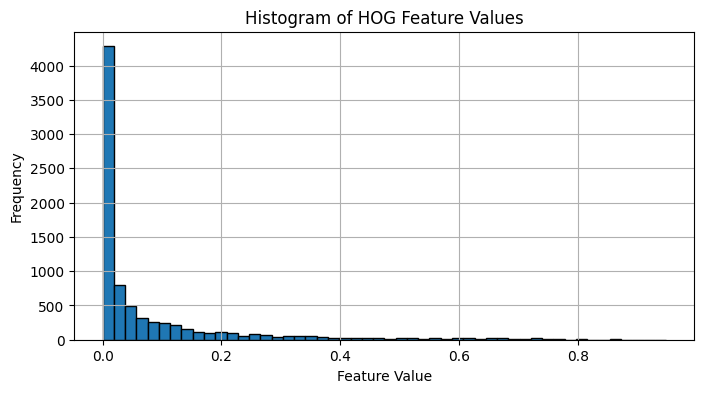

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(feature_vector, bins=50, edgecolor='black')
plt.title('Histogram of HOG Feature Values')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Conclusion
The HOG descriptor effectively captures edge patterns for object detection by processing gradients, histograms, and normalized features.